## Predict 2 meter temperature with sea surface temperature using linear regression
This notebook serves as an example of a basic workflow of data driven forecasting using machine learning with `s2spy` & `lilio` packages. <br>
We will predict temperature in US at seasonal time scales using ERA5 dataset with linear regression (Ridge). <br>

<img src="../assets/concept_test_case.png" alt="usecase" width="500"/>

This recipe includes the following steps:
- Define a calendar (`lilio`)
- Download/load input data (test data, accessible via `era5cli`)
- Map the calendar to the data (`lilio`)
- Train-test split (70%/30%)
- Preprocessing based on the training set (`s2spy`)
- Resample data to the calendar (`lilio`)
- Dimensionality reduction and model training, with cross-validation (`lilio` & `scikit-learn`)

The workflow is illustrated below:

<img src="../assets/regression.PNG" alt="Ridge" width="900"/>

In [30]:
import lilio
import numpy as np
import xarray as xr
from pathlib import Path
from s2spy import preprocess
from s2spy import RGDR
from sklearn.linear_model import RidgeCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

#### Define a calendar with `lilio` to specify time range for targets and precursors.

In [15]:
# create custom calendar based on the time of interest
calendar = lilio.Calendar(anchor="07-01", allow_overlap=True)
# add target periods
calendar.add_intervals("target", length="30d", gap="1M")
# add precursor periods
periods_of_interest = 8
calendar.add_intervals("precursor", "1M", n=periods_of_interest)

In [16]:
# check calendar
calendar

Calendar(
    anchor='07-01',
    allow_overlap=True,
    mapping=None,
    intervals=[
        Interval(role='target', length='30d', gap='1M'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d'),
        Interval(role='precursor', length='1M', gap='0d')
    ]
)

#### Load test data SST and (clustered) T2M
We use 63 years (1959-2021) of data.

In [17]:
# load data
precursor_field = xr.open_dataset('../data/sst_daily_1959-2021_5deg_Pacific_175_240E_25_50N.nc')
target_field = xr.open_dataset('../data/t2m_daily_1959-2021_2deg_clustered_226_300E_30_70N.nc')

In [18]:
# Convert Klevin to Celcius
precursor_field["sst"] = precursor_field["sst"] - 273.15
target_field["t2m"] = target_field["t2m"] - 273.15

#### Map the calendar to the data
After mapping the calendar to the field, we can visualize our calendar by calling the `visualize` method.

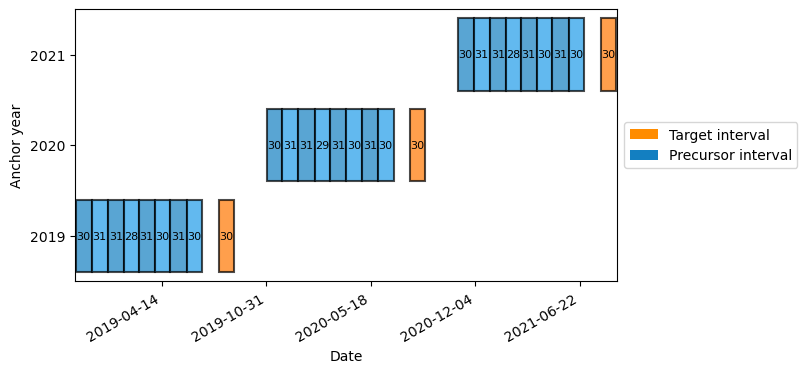

In [19]:
# map calendar to data
calendar.map_to_data(precursor_field)
calendar.visualize(show_length=True)

Also, we can get a list of all intervals by running the following line. There, you will find the intervals `-1` and `1`, which corresponds to the creation of a precursor interval (negative integer(s)) and a target interval (positive integer(s)), respectively. <br>

For more information about the definition of intervals, and how `lilio` works, please check the [README](https://github.com/AI4S2S/lilio) of `lilio`.

In [20]:
# show first 5 anchor years in the calendar
calendar.show()[:5]

i_interval,-8,-7,-6,-5,-4,-3,-2,-1,1
anchor_year,,,,,,,,,
2021,"[2020-11-01, 2020-12-01)","[2020-12-01, 2021-01-01)","[2021-01-01, 2021-02-01)","[2021-02-01, 2021-03-01)","[2021-03-01, 2021-04-01)","[2021-04-01, 2021-05-01)","[2021-05-01, 2021-06-01)","[2021-06-01, 2021-07-01)","[2021-08-01, 2021-08-31)"
2020,"[2019-11-01, 2019-12-01)","[2019-12-01, 2020-01-01)","[2020-01-01, 2020-02-01)","[2020-02-01, 2020-03-01)","[2020-03-01, 2020-04-01)","[2020-04-01, 2020-05-01)","[2020-05-01, 2020-06-01)","[2020-06-01, 2020-07-01)","[2020-08-01, 2020-08-31)"
2019,"[2018-11-01, 2018-12-01)","[2018-12-01, 2019-01-01)","[2019-01-01, 2019-02-01)","[2019-02-01, 2019-03-01)","[2019-03-01, 2019-04-01)","[2019-04-01, 2019-05-01)","[2019-05-01, 2019-06-01)","[2019-06-01, 2019-07-01)","[2019-08-01, 2019-08-31)"
2018,"[2017-11-01, 2017-12-01)","[2017-12-01, 2018-01-01)","[2018-01-01, 2018-02-01)","[2018-02-01, 2018-03-01)","[2018-03-01, 2018-04-01)","[2018-04-01, 2018-05-01)","[2018-05-01, 2018-06-01)","[2018-06-01, 2018-07-01)","[2018-08-01, 2018-08-31)"
2017,"[2016-11-01, 2016-12-01)","[2016-12-01, 2017-01-01)","[2017-01-01, 2017-02-01)","[2017-02-01, 2017-03-01)","[2017-03-01, 2017-04-01)","[2017-04-01, 2017-05-01)","[2017-05-01, 2017-06-01)","[2017-06-01, 2017-07-01)","[2017-08-01, 2017-08-31)"


#### Train-test split based on the anchor years (70%/30% split)
This can be refered to as the "outer cross-validation layer".

In [21]:
# get 70% of instance as training
years = sorted(calendar.get_intervals().index)
train_samples = round(len(years) * 0.7)
start_year = years[0]

#### Fit preprocessor with training samples and preprocess data
In this step, we remove trend and take anomalies for the precursor field. Note that here we use raw daily data for detrending and taking anomalies. <br>

In general, there are many "flavors" of preprocessing, like when to perform this operation, and in which order do we want to preprocess the data. To improve the transparency and reproducibility of our work, we think it is necessary to standardize these steps. To stick to the best practices, we suggest to preprocess your data in the following way.

In [22]:
# create preprocessor
preprocessor = preprocess.Preprocessor(
    rolling_window_size=25,
    detrend="linear",
    subtract_climatology=True,
)

# fit preprocessor with training data
preprocessor.fit(
    precursor_field.sel(
        time=slice(str(start_year), str(start_year + train_samples - 1))
    )
)

In [23]:
# preprocess the whole precursor field
precursor_field_prep = preprocessor.transform(precursor_field)

#### Resample data to the calendar

In [24]:
precursor_field_resample = lilio.resample(calendar, precursor_field_prep)
target_field_resample = lilio.resample(calendar, target_field)

In [25]:
# select variables and intervals
precursor_field_sel = precursor_field_resample['sst']
target_series_sel = target_field_resample['t2m'].sel(cluster=3)

#### Train-test split -> dimensionality reduction & model fitting
Train-test split based on the previous split, which can be refered to as "inner cross-validation layer" (outer cv loop -> inner cv loop). <br>
For each split, we will perform dimensionality reduction and fit the model.

For simplicity, in this example we only perform dimensionality reduction with RGDR with only one target interval and one lag. But in practice you can have multiple target intervals and multiple lags. <br>
For more information, here is a nice example about multiple target intervals in the [tutorial notebook](https://github.com/AI4S2S/s2spy/blob/main/docs/notebooks/tutorial_RGDR.ipynb) of RGDR.

In [31]:
# cross-validation with Kfold
k_fold_splits = 5
kfold = KFold(n_splits=k_fold_splits)
cv = lilio.traintest.TrainTestSplit(kfold)

# create lists for saving models and predictions
models = []
predictions = []
rmse_train = []
rmse_test = []
train_test_splits = []

# prepare operator for dimensionality reduction
target_intervals = 1
lag = 2
rgdr = RGDR(
    target_intervals=target_intervals,
    lag=lag,
    eps_km=600,
    alpha=0.05,
    min_area_km2=0
)

# cross validation based dimensionality reduction and model training
for x_train, x_test, y_train, y_test in cv.split(precursor_field_sel, y=target_series_sel):
    # log train/test splits with anchor years
    train_test_splits.append({
        "train": x_train.anchor_year.values,
        "test": x_test.anchor_year.values,
    })
    # fit dimensionality reduction operator RGDR
    rgdr.fit(x_train, y_train)
    # transform to train and test data
    clusters_train = rgdr.transform(x_train)
    clusters_test = rgdr.transform(x_test)
    # train model
    ridge = RidgeCV(alphas=[0.1, 10, 25, 50])
    model = ridge.fit(clusters_train.isel(i_interval=0), y_train.sel(i_interval=1))
    # save model
    models.append(model)
    # predict and save results
    prediction = model.predict(clusters_test.isel(i_interval=0))
    predictions.append(prediction)
    # calculate and save rmse
    rmse_train.append(mean_squared_error(y_train.sel(i_interval=1),
                                         model.predict(clusters_train.isel(i_interval=0))))
    rmse_test.append(mean_squared_error(y_test.sel(i_interval=1),
                                        prediction))

<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: invalid value encountered in cast
<__array_function__ internals>:200: RuntimeWarning: in

In [32]:
clusters_train

<xarray.DataArray 'sst' (anchor_year: 50, i_interval: 1, cluster_labels: 2)>
array([[[-0.97626738,  0.44366444]],

       [[-0.35536136, -0.16670312]],

       [[ 0.49199139, -0.06453097]],

       [[ 0.53587579, -0.0327614 ]],

       [[ 0.45312712,  0.12878606]],

       [[ 0.88973063, -0.53432375]],

       [[ 0.4807509 , -0.28606691]],

       [[ 0.51968035, -0.65672427]],

       [[ 0.50233281,  0.11060942]],

       [[-0.68087629,  0.50536389]],

...

       [[-0.66575862,  2.31406735]],

       [[-0.39876976,  1.31702337]],

       [[ 0.77408958, -0.87420737]],

       [[-0.36998757,  0.12183744]],

       [[ 0.28319172, -1.22992618]],

       [[ 0.50763789,  0.8780428 ]],

       [[-0.33881888,  0.89358637]],

       [[-0.27616542,  0.6507888 ]],

       [[ 0.31922811,  0.98354972]],

       [[ 1.04343428,  0.15593146]]])
Coordinates:
  * anchor_year     (anchor_year) int64 1960 1961 1962 1963 ... 2007 2008 2009
  * i_interval      (i_interval) int64 -2
    left_bound      (anchor_year, i_interval) datetime64[ns] 1960-05-01 ... 2...
    right_bound     (anchor_year, i_interval) datetime64[ns] 1960-06-01 ... 2...
    is_target       (i_interval) bool False
  * cluster_labels  (cluster_labels) int16 -1 1
    latitude        (cluster_labels) float64 42.59 27.5
    longitude       (cluster_labels) float64 208.0 190.0
Attributes:
    data:         Clustered data with Response Guided Dimensionality Reduction.
    coordinates:  Latitudes and longitudes are geographical centers associate...

#### Plot the RMSE for both training and testing for each experiment (split)

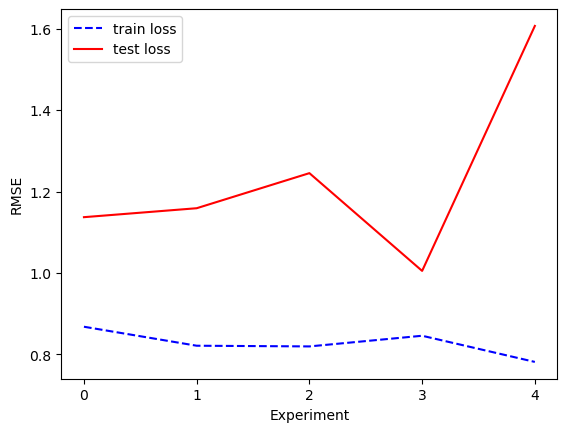

In [33]:
import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(range(k_fold_splits), rmse_train, "b--", label = "train loss")
plt.plot(range(k_fold_splits), rmse_test, "r", label = "test loss")
ax = fig.gca()
ax.set_xticks(range(k_fold_splits))
plt.xlabel("Experiment")
plt.ylabel("RMSE")
plt.legend()
plt.show()